# 3D Data Processing

---
A.A. 2022/2023 - Dr. Daniel Fusaro
---


## Lab - TinyPointNet: Point Cloud 3D Descriptors

original paper -
[PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation](https://web.stanford.edu/~rqi/pointnet/)

dataset link: https://drive.google.com/drive/folders/1IweJGcOeOZN3wY79i2jFt3JE1bd7G51Z?usp=share_link

To add a link to the dataset in your Google Drive main folder, you need to:

 - Click on the link
 - Right click on "dataset"
 - Click Add shortcut to Drive

When you will mount your drive folder in Colab you will find this folder without the need of re-uploading it.

# Install/import required packages

In [ ]:
# useful for visualization
## PLEASE NOTE : it may be necessary to restart the notebook environment after installation
!pip install open3d

In [ ]:
import numpy as np
import random
import math
import time
import copy
import os
import glob

import matplotlib.pyplot as plt

# pyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# a nice training progress bar
from tqdm import tqdm, trange

# visualization
import open3d as o3d

running_on_colab = True

if running_on_colab:
  import plotly.graph_objects as go



# Connect and mount your Google Drive

In [ ]:
if running_on_colab:
    from google.colab import drive
    drive_path = '/content/drive'
    drive.mount(drive_path)

# General Parameters

In [ ]:
dataset_path_train = os.path.join(drive_path, "MyDrive", "3dshapes", "train")
dataset_path_valid = os.path.join(drive_path, "MyDrive", "3dshapes", "valid")
dataset_path_test = os.path.join(drive_path,  "MyDrive", "3dshapes", "test")

# Visualization Example
In order to visualize colored point clouds we make use of the Python package *Open3D*.

Unfortunately, the original doesn't run on Colab.
So, we replace the drawing function with a custom one (*draw_geometries*) that allows for rendering here on Colab.



In [ ]:
if running_on_colab:
    def draw_geometries(geometries):
        graph_objects = []

        for geometry in geometries:
            geometry_type = geometry.get_geometry_type()

            if geometry_type == o3d.geometry.Geometry.Type.PointCloud:
                points = np.asarray(geometry.points)
                colors = None
                if geometry.has_colors():
                    colors = np.asarray(geometry.colors)
                elif geometry.has_normals():
                    colors = (0.5, 0.5, 0.5) + np.asarray(geometry.normals) * 0.5
                else:
                    geometry.paint_uniform_color((1.0, 0.0, 0.0))
                    colors = np.asarray(geometry.colors)

                scatter_3d = go.Scatter3d(x=points[:,0], y=points[:,1], z=points[:,2], mode='markers', marker=dict(size=1, color=colors))
                graph_objects.append(scatter_3d)

            if geometry_type == o3d.geometry.Geometry.Type.TriangleMesh:
                triangles = np.asarray(geometry.triangles)
                vertices = np.asarray(geometry.vertices)
                colors = None
                if geometry.has_triangle_normals():
                    colors = (0.5, 0.5, 0.5) + np.asarray(geometry.triangle_normals) * 0.5
                    colors = tuple(map(tuple, colors))
                else:
                    colors = (1.0, 0.0, 0.0)

                mesh_3d = go.Mesh3d(x=vertices[:,0], y=vertices[:,1], z=vertices[:,2], i=triangles[:,0], j=triangles[:,1], k=triangles[:,2], facecolor=colors, opacity=0.50)
                graph_objects.append(mesh_3d)

        fig = go.Figure(
            data=graph_objects,
            layout=dict(
                scene=dict(
                    xaxis=dict(visible=False),
                    yaxis=dict(visible=False),
                    zaxis=dict(visible=False),
                    aspectmode='data'
                )
            )
        )
        fig.show()

In [ ]:
if running_on_colab:
    o3d.visualization.draw_geometries = draw_geometries

anchor_color   = [0, 0, 1.0] # blue
positive_color = [0, 1.0, 0] # green
negative_color = [1.0, 0, 0] # red
p_colors = [anchor_color, positive_color, negative_color]

def visualize( pointcloud:np.array =None,
               anchor    :np.array =None,
               positive  :np.array =None,
               negative  :np.array =None,
               radius    :np.array =None ):
    """
    INPUT
      pointcloud : numpy array of 3D points
      anchor     : anchor point
      positive   : 
      negative   : 
    """
    
    geoms = []
    if pointcloud is not None:
        pcd = o3d.geometry.PointCloud()
        ### PLEASE NOTE: we downsample the point cloud to avoid heavy rendering
        pcd.points = o3d.utility.Vector3dVector(np.random.permutation(pointcloud)[:3000])
        pcd.paint_uniform_color([0.6, 0.6, 0.6])
        geoms.append(pcd)
    for point, color in zip([anchor, positive, negative], p_colors):
        if point is not None:
            assert radius is not None
            sphere = o3d.geometry.TriangleMesh.create_sphere(radius=radius, resolution=20)
            sphere.translate(point)
            sphere = sphere.sample_points_uniformly(20000)
            sphere_pc = o3d.geometry.PointCloud()
            sphere_pc.points = o3d.utility.Vector3dVector(sphere.points)
            sphere_pc.paint_uniform_color(color)
            geoms.append(sphere_pc)
    # visualize the colored point cloud
    o3d.visualization.draw_geometries(geoms)

# PointCloud Dataset

`torch.utils.data.Dataset` is an abstract class representing a dataset. Your custom dataset should inherit `Dataset` and override the following methods:

* `__init__` to initialize your dataset. For example, if your dataset fits in memory, you can load the entire dataset in a list, or you can just store the list of dataset files.
* `__len__` so that len(dataset) returns the size of the dataset.
* `__getitem__` to support indexing such that `dataset[i]` can be used to get  the i-th sample

Therefore, the structure of the class is:

```
class CustomDataset(Dataset):

    def __init__(self, init_parameters):
        self.param1 = param1
        [...]

    def __len__(self):
        [...]

    def __getitem__(self, idx):
        [...]

        return sample[idx]
```


In [ ]:
class PointCloudData(Dataset):
    def __init__(self, 
                dataset_path: str,
                samples_per_epoch: int,
                points_to_sample:int = 200000,
                radius:float =2*10.0e-3,
                min_dist=15.0e-3,
                N = 750,
                noise_mean=0,
                noise_variance = 6e-5):
      
        self.radius = radius
        self.min_dist = min_dist
        self.N = N
        self.samples_per_epoch = samples_per_epoch
        self.points_to_sample = points_to_sample
        self.noise_mean = noise_mean
        self.noise_variance = noise_variance
        
        # _n means noised version
        self.mesh = []
        self.pcds, self.pcds_n = [], []
        self.KDtrees, self.KDtrees_n = [], []
        
        
        for file in glob.glob(dataset_path + "/*.ply"):
            print("parsing file", file)
            mesh = o3d.io.read_triangle_mesh(file)
            pcd1 = mesh.sample_points_uniformly(self.points_to_sample)
            pcd1_tree = o3d.geometry.KDTreeFlann(pcd1)
            
            pcd2 = self.apply_noise(mesh.sample_points_uniformly(self.points_to_sample), self.noise_mean, self.noise_variance)
            pcd2_tree = o3d.geometry.KDTreeFlann(pcd2)
            
            self.mesh.append(mesh)
            
            self.pcds.append(np.asarray(pcd1.points))
            self.pcds_n.append(np.asarray(pcd2.points))
            
            self.KDtrees.append(pcd1_tree)
            self.KDtrees_n.append(pcd2_tree)
    
    # function to apply noise
    def apply_noise(self, pcd, mu, sigma):
        noisy_pcd = copy.deepcopy(pcd)
        points = np.asarray(noisy_pcd.points)
        points += np.random.normal(mu, sigma, size=points.shape)
        noisy_pcd.points = o3d.utility.Vector3dVector(points)
        return noisy_pcd

    def __len__(self):
        return self.samples_per_epoch

    def __getitem__(self, _):
      while True:
        mesh_idx = np.random.randint(0, len(self.mesh))
        
        pcd1_points = self.pcds[mesh_idx]
        pcd2_points = self.pcds_n[mesh_idx]
        
        ################# START #################
        ############# COMPLETE HERE #############
        # ANCHOR: select a random anchor point pt1
        # find neighborhood of pt1
        
        # POSITIVE: find corresponding point in pdc2
        # find neighborhood of pt2
        
        # NEGATIVE: find far point (at least at distance min_dist)
        # find neighborhood of neg_pt

        # get points
        
        # normalize points

        ################# END #################

        ## apply a rotation to a point set to improve the generalization capability
        ## apply a random rotation to positive point set
        xyz = np.random.rand(3) * 2 * np.pi
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(point_set2)
        Rpos = pcd.get_rotation_matrix_from_xyz((xyz[0], xyz[1], xyz[2]))
        pcd.rotate(Rpos, center=(0, 0, 0))
        point_set2 = np.asarray(pcd.points)

        ## apply a random rotation to negative point set
        xyz = np.random.rand(3) * 2 * np.pi
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(point_set3)
        Rneg = pcd.get_rotation_matrix_from_xyz((xyz[0], xyz[1], xyz[2]))
        pcd.rotate(Rneg, center=(0, 0, 0))
        point_set3 = np.asarray(pcd.points)
        
        # copy points coordinates to a fixed dimension np.array
        pc1 = np.zeros((self.N, 3), dtype=np.float32)
        pc2 = np.zeros((self.N, 3), dtype=np.float32)
        pc3 = np.zeros((self.N, 3), dtype=np.float32)
        
        pc1[:min(self.N, point_set1.shape[0]), :] = point_set1[:min(self.N, point_set1.shape[0]), :]
        pc2[:min(self.N, point_set2.shape[0]), :] = point_set2[:min(self.N, point_set2.shape[0]), :]
        pc3[:min(self.N, point_set3.shape[0]), :] = point_set3[:min(self.N, point_set3.shape[0]), :]
    
        # transform
        torch_point_set1  = torch.from_numpy(pc1)
        torch_point_set2  = torch.from_numpy(pc2)
        torch_point_set3  = torch.from_numpy(pc3)
        
        return mesh_idx, torch_point_set1, torch_point_set2, torch_point_set3, pt1, pt2, neg_pt

# Dataset Creation

Now we can instantiate our training and test dataset objects.

In [ ]:
train_ds  = PointCloudData(dataset_path_train, samples_per_epoch=500)
valid_ds  = PointCloudData(dataset_path_valid, samples_per_epoch=500)
test_ds   = PointCloudData(dataset_path_test,  samples_per_epoch=500)

Creating a `Dataset` class may seem unnecessary for the most basic problems. But it really helps when the dataset and the training procedure start to get more complex.

One of the most useful benefit of defining a `Dataset` class is the possiblity to use the PyTorch `Dataloader` module.

By operating on the dataset directly, we are losing out on a lot of features by using a simple for loop to iterate over the data. In particular, we are missing out on:

* Batching the data
* Shuffling the data
* Load the data in parallel using multiprocessing workers.

`torch.utils.data.DataLoader` is an iterator which provides all these features. Parameters used below should be clear.

In [ ]:
# warning: batch_size needs to be at least 2
train_loader  = DataLoader( dataset=train_ds,  batch_size=50, shuffle=True  )
valid_loader  = DataLoader( dataset=valid_ds,  batch_size=50, shuffle=False )
test_loader   = DataLoader( dataset=test_ds,   batch_size=50,  shuffle=False )

# Visualize some data

In [ ]:
ds = train_ds

for (mesh_idx, _, _, _, anchor, positive, negative) in ds:
    idx = mesh_idx
    visualize(ds.pcds[idx],
              anchor = anchor, 
              positive = positive,
              negative = negative,
              radius=ds.radius)
    break
    

# Network Definition

## Network Base Module

A network is defined by extending the *torch.nn.module* class. The basic structure is:

```
class Net(nn.Module):
    
    def __init__(self, input_parameters):
        super().__init__() # This executes the parent __init__ method
        [...]

    def forward(self, x, optional_parameters):
        [...]
        return out # return the output of the network
```

You need to define two methods:
*   **\_\_init\_\_**: The constructor method. This is exectuted when the object is initialized (no need to call it explicitly). Here you have to instantiate all the network's parameters. PyTorch provides utility functions to easily initialize most of the commonly used deep learning layers.
*   **forward**: Here you define the forward pass of the network, from the input *x* to the output (the method must return the network output). You just need to define the forward part, the back-propagation is automatically tracked by the framework!

In [ ]:
# Multi Layer Perceptron
class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.input_size   = input_size
        self.output_size  = output_size
        self.conv  = nn.Conv1d(self.input_size, self.output_size, 1)
        self.bn    = nn.BatchNorm1d(self.output_size)

    def forward(self, input):
        return F.relu(self.bn(self.conv(input)))

# Fully Connected with Batch Normalization
class FC_BN(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.input_size   = input_size
        self.output_size  = output_size
        self.lin  = nn.Linear(self.input_size, self.output_size)
        self.bn    = nn.BatchNorm1d(self.output_size)

    def forward(self, input):
        return F.relu(self.bn(self.lin(input)))

class TNet(nn.Module):
    def __init__(self, k=3):
        super().__init__()
        self.k=k

        self.mlp1 = MLP(self.k, 64)
        self.mlp2 = MLP(64, 128)
        self.mlp3 = MLP(128, 1024)

        self.fc_bn1 = FC_BN(1024, 512)
        self.fc_bn2 = FC_BN(512,256)

        self.fc3 = nn.Linear(256,k*k)
    

    def forward(self, input):
        # input.shape == (batch_size,n,3)

        bs = input.size(0)
        xb = self.mlp1(input)
        xb = self.mlp2(xb)
        xb = self.mlp3(xb)

        pool = nn.MaxPool1d(xb.size(-1))(xb)
        flat = nn.Flatten(1)(pool)

        xb = self.fc_bn1(flat)
        xb = self.fc_bn2(xb)

        #initialize as identity
        init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
        if xb.is_cuda:
            init=init.cuda()
        matrix = self.fc3(xb).view(-1,self.k,self.k) + init
        return matrix

In [ ]:
class TinyPointNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_transform   = TNet(k=3)
        
        ############# START ###########
        ######### COMPLETE HERE #######
        ############# END #############

    def forward(self, input):
        n_pts = input.size()[2]
        matrix3x3 = self.input_transform(input)
        input_transform_output = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        ############# START ###########
        ######### COMPLETE HERE #######
        ############# END #############

        # output need to be:
        #   global_feature: torch.Tensor 

        return global_feature


# Training loop

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
tinypointnet = TinyPointNet()
tinypointnet.to(device);

In [ ]:
optimizer = torch.optim.Adam(tinypointnet.parameters(), lr=0.005)

In [ ]:
def train(model, train_loader, valid_loader=None,  epochs=45, save=True):
    best_valid_loss = 1e10
    ############## START #############
    ####### COMPLETE THIS PART: put the correct loss function #######
    # tinypointnetloss = 
    ############## END ###############
    
    # these lists keep track of the losses across epochs
    train_losses, valid_losses = [], []
    
    for epoch in range(epochs):
        # local list of losses
        train_loss, valid_loss = [], []
        
        # train 
        tinypointnet.train()
        
        pbar = tqdm(train_loader, leave=False)
        
        for (_, anchor, positive, negative, _, _, _) in pbar:
            pbar.set_description(f"train - epoch {epoch} - ")
            
            # retrieve anchors, positives and negatives batch
            anchor   =   anchor.to(device).float().transpose(1,2)
            positive = positive.to(device).float().transpose(1,2)
            negative = negative.to(device).float().transpose(1,2)

            optimizer.zero_grad()
            
            # let PointNetTiny model compute the descriptors
            anchor_desc   = tinypointnet(anchor)
            positive_desc = tinypointnet(positive)
            negative_desc = tinypointnet(negative)
            
            # compute the loss associated to these descriptors
            loss = tinypointnetloss(anchor_desc, positive_desc, negative_desc)
            
            # Backpropagate the gradient
            loss.backward()
            optimizer.step()
            
            # Keep track of the statistics            
            curr_loss = loss.item()
            train_loss.append(curr_loss)
            pbar.set_postfix(loss=curr_loss)
        
        train_loss = np.asarray(train_loss).mean()
        print(f'epoch {epoch} - train loss:', train_loss)
        train_losses.append(train_loss)

        # validation
        tinypointnet.eval()
        pbar = tqdm(valid_loader, leave=False)
        
        with torch.no_grad():
            for (_, anchor, positive, negative, _, _, _) in pbar:
                pbar.set_description(f"valid - epoch {epoch}")
                
                anchor   =   anchor.to(device).float().transpose(1,2)
                positive = positive.to(device).float().transpose(1,2)
                negative = negative.to(device).float().transpose(1,2)
                
                anchor_desc   = tinypointnet(anchor)
                positive_desc = tinypointnet(positive)
                negative_desc = tinypointnet(negative)
                loss = tinypointnetloss(anchor_desc, positive_desc, negative_desc)
                curr_loss = loss.item()
                
                valid_loss.append(curr_loss)
                
                pbar.set_postfix(loss=curr_loss)
        
        valid_loss = np.asarray(valid_loss).mean()
        print(f'epoch {epoch} - valid loss:', valid_loss)
        valid_losses.append(valid_loss)        

        # save the model
        if save and valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            path = os.path.join(drive_path, "MyDrive", "tinypointnetmodel.yml")
            print("best_valid_loss:", best_valid_loss, "saving model at", path)
            torch.save(tinypointnet.state_dict(), path)
    return train_losses, valid_losses
        

In [ ]:
train_losses, valid_losses = train(tinypointnet, train_loader, valid_loader, save=True)

## Visualize the Training trend

In [ ]:
def numpy_ewma_vectorized_v2(data, window=10):
    # Return the Exponentially Weighted Moving Average
    # for better visualizing the "trend" of the metrics

    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n+1))

    scale_arr = 1/pows[:-1]
    offset = data[0]*pows[1:]
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

### Plot the trend of train and valid losses
By using an Exponentially Weighted Moving Average of the losses,
we can better understand the behaviour of our network by filtering out
the noisy *local values* and focusing more on the *global trend*.

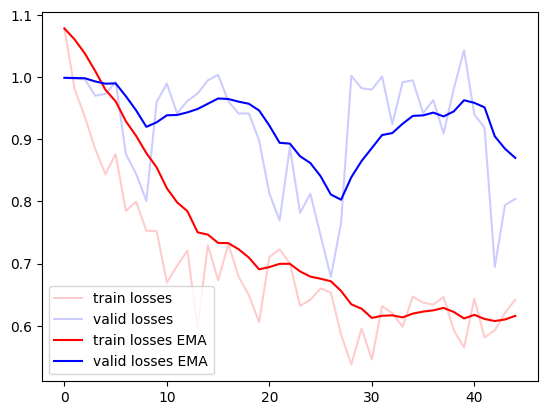

In [ ]:
plt.plot(train_losses, label="train losses", color='r', alpha=0.2)
plt.plot(valid_losses, label="valid losses", color='b', alpha=0.2)
plt.plot(numpy_ewma_vectorized_v2(np.array(train_losses)), label="train losses EMA", color='r')
plt.plot(numpy_ewma_vectorized_v2(np.array(valid_losses)), label="valid losses EMA", color='b')
plt.legend()

# Test: feature matching

We will test the performance of the trained model by verifying its ability to match very similar key points.

We will use a mesh from the test set, we will add noise to it, and pick N keypoints from the original one. By taking the _true_ nearest neighbor of each keypoint in the noised point cloud version of the mesh, we will compute the descriptors of both the original keypoints and the nearest neighbor keypoints.

The model will have a true match in describing a keypoint if the L2 norm between the descriptor of a keypoint in the original cloud and the descriptor of the keypoint having the minimum L2 norm with respect to our input keypoint is less than the radius used to compute the nearest neighbors points.

In other words, lets say that we have an input keypoint $p_i$.
Let $d_i$ be its descriptor, calculated by the model, such that $d_i = f(p_i)$.

Let $P'$ be the set of all the keypoints in the perturbed cloud.
If we say that $p'^* = arg\,min_{p' \in P'} ||d_i - f(p')||_2$ is the keypoint in the perturbed cloud having the descriptor with the lowest distance from $d_i$, then if 

$||p_i - p'^*||_2 < r$

with $r$ being the radius used to extract nearest neighbors for descriptor computing, we say that we have a True match.



In [ ]:
# First we need to load the best model weights
path = os.path.join(drive_path, "MyDrive", "tinypointnetmodel.yml")
tinypointnet = TinyPointNet()
tinypointnet.load_state_dict(torch.load(path))
tinypointnet.to(device)

In [ ]:
points_to_sample = test_ds.points_to_sample
radius=test_ds.radius
min_dist=test_ds.min_dist
N = test_ds.N
noise_mean=test_ds.noise_mean
noise_variance = test_ds.noise_variance

Now we do the following:
 - compute the set of keypoints in the original mesh
 - find the Nearest Neighbor to each of the original keypoints in the perturbed cloud

In [ ]:
mesh = mesh = test_ds.mesh[0]

pcd1 = mesh.sample_points_uniformly(points_to_sample)
pcd2 = train_ds.apply_noise(mesh.sample_points_uniformly(points_to_sample), noise_mean, noise_variance)

pcd1_points = np.asarray(pcd1.points)
pcd2_points = np.asarray(pcd2.points)

keypoints = o3d.geometry.keypoint.compute_iss_keypoints(pcd1,
                                                        salient_radius=0.005,
                                                        non_max_radius=0.005,
                                                        gamma_21=0.4,
                                                        gamma_32=0.5)
pcd1_points_sampled = np.random.permutation(np.asarray(keypoints.points))[:100]
pcd2_tree = o3d.geometry.KDTreeFlann(pcd2)

pcd2_points_sampled = []
for i in tqdm(range(pcd1_points_sampled.shape[0])):
  pt = pcd1_points_sampled[i]

  k2, idx2, _ = pcd2_tree.search_knn_vector_3d(pt, 1)
  pt2 = pcd2_points[idx2].squeeze()
  pcd2_points_sampled.append(pt2)

pcd2_points_sampled = np.asarray(pcd2_points_sampled)

### Let's visualize a pair original keypoint - perturbed keypoint

In [ ]:
idx = 0
visualize(pcd1_points,
          anchor = pcd1_points_sampled[idx], 
          positive = pcd2_points_sampled[idx],
          radius=test_ds.radius)

### Let's compute the descriptors of each keypoint

In [ ]:

tinypointnet.eval()

def compute_feats(pcd, pcd_points, pcd_points_sampled):
    pcd_tree = o3d.geometry.KDTreeFlann(pcd)
    feats = np.zeros((pcd_points_sampled.shape[0], 256), dtype=np.float32)

    pts = []
    
    for i in tqdm(range(pcd_points_sampled.shape[0])):
        pt = pcd_points_sampled[i]
        k, idx, _ = pcd_tree.search_radius_vector_3d(pt, radius)

        pts.append(pt)

        point_set = pcd_points[idx]
        point_set = (point_set - pt)

        pc = np.zeros((N, 3), dtype=np.float32)
        pc[:min(N, point_set.shape[0]), :] = point_set[:min(N, point_set.shape[0]), :]

        # transform
        anchor  = torch.from_numpy(pc).unsqueeze(0)

        anchor = anchor.to(device).float()
        anchor_desc   = tinypointnet(anchor.transpose(1,2))[0, :, 0]
        feats[i, :] = anchor_desc.cpu().detach().numpy()
    return feats, pts

feats_1, pts1 = compute_feats(pcd1, pcd1_points, pcd1_points_sampled)
feats_2, pts2 = compute_feats(pcd2, pcd2_points, pcd2_points_sampled)


### Test time! Let's associate the descriptors with respect to their L2 norm

In [ ]:
pcd2 = o3d.geometry.PointCloud()
pcd2.points = o3d.utility.Vector3dVector(pcd2_points_sampled)

pcd2_tree = o3d.geometry.KDTreeFlann(pcd2)

correct = tot = 0

for row in tqdm(range(pcd1_points_sampled.shape[0])):
  feat1 = feats_1[row, :]
  dists = []
  anchor = pts1[row]

  k2, idx2, _ = pcd2_tree.search_knn_vector_3d(anchor, 1)
  true_near_pt = pcd2_points_sampled[idx2].squeeze()

  for row2 in range(pcd2_points_sampled.shape[0]):
    feat2 = feats_2[row2, :]
    dist = np.linalg.norm(feat1 - feat2)
    dists.append(dist)

  dists = np.asarray(dists)
  min_row = np.argmin(dists)

  pred_pt = pcd2_points_sampled[min_row].squeeze()

  dist = np.linalg.norm(true_near_pt - pcd2_points_sampled[min_row].squeeze())

  # visualize(pcd1_points,
  #           anchor = anchor, 
  #           positive = pred_pt,
  #           radius=ds.radius)

  if dist<radius:
    correct += 1
  tot += 1

print()
print(f"accuracy: {correct*100/tot:6.3f}%")

